<a href="https://colab.research.google.com/github/ashishlamsal/sentiment-analysis/blob/main/notebooks/binary-sentiment-analysis-for-Nepali-text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install wandb
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 97.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 80.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 17.9 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes:

In [4]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
    
Token: 
Add token as git credential? (Y/n) 
Token is valid.
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper 

In [ ]:
%env WANDB_NOTEBOOK_NAME='sentiment-analysis-for-Nepali-text.ipynb'
%env WANDB_LOG_MODEL=true
import wandb
wandb.login()

env: WANDB_NOTEBOOK_NAME='sentiment-analysis-for-Nepali-text.ipynb'
env: WANDB_LOG_MODEL=true


wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find 'sentiment-analysis-for-Nepali-text.ipynb'.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb.init(project="binary-sentiment-analysis")

wandb: Currently logged in as: ashishlamsal (ashish-team). Use `wandb login --relogin` to force relogin


In [5]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# Load Dataset

In [6]:
from datasets import load_dataset, ClassLabel, DatasetDict, load_from_disk
import pandas as pd

In [7]:
# load dataset 
path = r"/content/drive/MyDrive/fusemachines/sentiment-analysis/dataset/clean/binary_dataset.csv"
ds = load_dataset("csv", data_files=path, split='train')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-a08d53f3f07d4910/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


In [8]:
# dataset features (column)
ds.features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

In [9]:
# convert label to type ClassLabel
features = ds.features.copy()
features["label"] = ClassLabel(num_classes=2, names=["negative", "positive"])

def adjust_labels(batch):
    batch["label"] = [(sentiment + 1) // 2  for sentiment in batch["label"]]
    return batch

ds = ds.map(adjust_labels, batched=True, features=features)

  0%|          | 0/29 [00:00<?, ?ba/s]

In [8]:
# first five sentences
ds[:5]

{'text': ['अमेरिकामा कोभिड बाट एकै दिन चार हजारभन्दा बढीको मृत्यु',
  'कोभिड का कारण विदेशमा रहेका नेपालीहरुमा मानसिक स्वास्थ्य सम्बन्धि समस्या देखिएको र आत्महत्याका घटनाहरु बढेको डा सापकोटाले बताए',
  'नेपालमा क्लोभर बायोफार्मास्युटिकल्स अस्ट्रेलिया तथा भ्याक्जाइन पीटीवाई लिमिटेड अस्ट्रेलियाले उत्पादन गरेका कोभिड खोपको तेस्रो चरणका ट्रायल गर्न तयारी भइरहेको छ',
  'अमेरिकामा कोभिड को नयाँ रेकर्ड एकै दिन हजारभन्दा बढीको मृत्यु विश्व समाचार',
  'गण्डकी प्रदेश सरकारले कोभिड बाट प्रभावीतहरुको लागि भनेर स्थापित व्यवसाय जीवन रक्षा कोषमा अर्ब छुट्याइएकोमा महिना लागि सक्दा पनि कार्यविधि समेत बनेको छैन यसबाट बजेट कार्यन्वयनको पक्ष कस्तो छ अनुमान लगाउन सकिन्छ'],
 'label': [0, 0, 1, 0, 0]}

In [9]:
# label
(ds.features['label'].int2str(0), ds.features['label'].int2str(1))

('negative', 'positive')

In [10]:
# dimensions
(ds.num_rows, ds.num_columns)

(28233, 2)

# Train-Validation-Test split

In [11]:
# 80% train, 10% validation + 10% test
train_valid_test = ds.train_test_split(test_size=0.2, stratify_by_column="label")

In [12]:
# Split the 20% validation + test in half validation, half test
valid_test = train_valid_test['test'].train_test_split(test_size=0.5, stratify_by_column="label")

In [13]:
ds = DatasetDict({
    'train': train_valid_test['train'],
    'validation': valid_test['train'], 
    'test': valid_test['test']
})

In [14]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 22586
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2823
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2824
    })
})

In [15]:
ds['train'].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'positive'], id=None)}

In [ ]:
# Arrow format
# ds.save_to_disk('/content/drive/MyDrive/fusemachines/sentiment-analysis/dataset/clean/binary-covid-sentiment/')

Flattening the indices:   0%|          | 0/22 [00:00<?, ?ba/s]

Saving the dataset (0/1 shards):   0%|          | 0/21174 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/4 [00:00<?, ?ba/s]

Saving the dataset (0/1 shards):   0%|          | 0/3529 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/4 [00:00<?, ?ba/s]

Saving the dataset (0/1 shards):   0%|          | 0/3530 [00:00<?, ? examples/s]

In [18]:
# save dataset to huggingface hub
# ds.push_to_hub("ashishlamsal/binary-sentiment-analysis-nepali")

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

# Model Fine-tuning

In [19]:
import os
import time
import datetime
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import get_polynomial_decay_schedule_with_warmup
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

In [20]:
checkpoint = "google/muril-base-cased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [21]:
id2label= {
    0: "negative",
    1: "postive"
}

label2id = {
    "negative": 0,
    "postive": 1
}

In [22]:
config = AutoConfig.from_pretrained(checkpoint, label2id=label2id, id2label=id2label, classifier_dropout=0.1)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config)
model.to(device)

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/206 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/113 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/953M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/muril-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not in

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(197285, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [23]:
config

BertConfig {
  "_name_or_path": "google/muril-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": 0.1,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "postive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "postive": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 197285
}

In [41]:
# ds = load_from_disk('/content/drive/MyDrive/fusemachines/sentiment-analysis/dataset/clean/binary-covid-sentiment')

/usr/local/lib/python3.8/dist-packages/datasets/dataset_dict.py:1241: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


In [24]:
# load from huggingface
ds = load_dataset("ashishlamsal/binary-sentiment-analysis-nepali")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/2824 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2823 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/22586 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/ashishlamsal___parquet/ashishlamsal--binary-sentiment-analysis-nepali-aa58d4e74d4d5730/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [42]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 21174
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 3529
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3530
    })
})

In [43]:
# test tokenizer
sequence = ds['train']['text'][:5]
print(sequence)

tokens = tokenizer.tokenize(sequence, is_split_into_words=True)
print(tokens)

tokens = tokenizer(sequence)
print(tokens)

['कोभिड विरुद्ध लड्न एडिबीद्वारा करोड अनुदान', 'कोभिड कोरोना भाईरस विरुद्धको यो युद्धमा अग्रमोर्चामा रहेर लड्नु हुने सम्पुर्ण चिकित्सक नर्स स्वास्थ्यकर्मी र सुरक्षाकर्मीहरुलाई झन्डा सलाम सहित प्रोत्साहन गरौ हततोसाहित नगरौ', 'नेकपा बिबादित अहिले जनता भोकै छन कोभिड को चपेटामा पुरा विश्व त्रहिमाम छ हाम्रा भेडा जस्ता नेताहरु शक्ती सन्चय गर्न तचाड माछाड गर्दै हिडिरहेका छन काही नभको जत्रा हाम्रो देशमा जनता हरु कतिन्जेल एस्ता दुखी आत्मा हरु लाई भोट दिन्छौ', 'चितवनमा महिने शिशुसहित एकैदिन जनामा कोरोना भाइरस कोभिड संक्रमण पुष्टि भएको छ', 'सेनाले दियो कोरोना भाईरस कोभिड सम्बन्धी दुई दिने प्रशिक्षण']
['को', '##भि', '##ड', 'विरुद्ध', 'लड्न', 'एड', '##िब', '##ीद', '##्वारा', 'करोड', 'अनुदान', 'को', '##भि', '##ड', 'कोर', '##ोना', 'भाई', '##रस', 'विरुद्धको', 'यो', 'युद्धमा', 'अग्र', '##मोर', '##्चा', '##मा', 'रहेर', 'लड्न', '##ु', 'हुने', 'सम्पुर्ण', 'चिकित्सक', 'नर्स', 'स्वास्थ्य', '##कर्मी', 'र', 'सुरक्षा', '##कर्मी', '##हरुलाई', 'झन्', '##डा', 'सलाम', 'सहित', 'प्रोत्साहन', 'गर', '##ौ', 'ह', '##त',

In [44]:
def tokenize_function(example):
    return tokenizer(example["text"], padding=True, truncation=True, return_tensors ="pt")

tokenized_datasets = ds.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [45]:
tokenized_datasets['train'][0]

{'text': 'कोभिड विरुद्ध लड्न एडिबीद्वारा करोड अनुदान',
 'label': 1,
 'input_ids': [104,
  1125,
  46093,
  2405,
  7555,
  174359,
  46907,
  48737,
  59367,
  61266,
  12548,
  26504,
  105,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,

In [46]:
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

['label', 'input_ids', 'token_type_ids', 'attention_mask']

In [47]:
train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=64, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], batch_size=64, collate_fn=data_collator
)
test_dataloader = DataLoader(
    tokenized_datasets["test"], batch_size=64, collate_fn=data_collator
)


In [48]:
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'input_ids': torch.Size([64, 94]),
 'token_type_ids': torch.Size([64, 94]),
 'attention_mask': torch.Size([64, 94]),
 'labels': torch.Size([64])}

In [49]:
outputs = model(**batch.to(device))
print(outputs.loss, outputs.logits.shape)

tensor(0.1410, device='cuda:0', grad_fn=<NllLossBackward0>) torch.Size([64, 2])


In [ ]:
num_epochs = 10
num_training_steps = num_epochs * len(train_dataloader)

optimizer = AdamW(model.parameters(), lr=5e-5)
lr_scheduler = get_polynomial_decay_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0.1*num_training_steps,
    num_training_steps=num_training_steps,
)

print(num_training_steps)

3310


In [ ]:
# import shutil
# shutil.rmtree('./checkpoints/')

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
def save_checkpoint(model, epoch_i, output_dir):
    output_path = os.path.join(output_dir, f"checkpoint-{epoch_i}")

    os.makedirs(output_path, exist_ok=True)
    print(f"Saving model checkpoint to {output_path}")
    
    tokenizer.save_pretrained(output_path)
    model.save_pretrained(output_path, state_dict=model.state_dict())

In [31]:
def validate_model(model, data_loader, desc="Validating"):
    print('Predicting labels for {:,} batches...'.format(len(data_loader)))
    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.

    class_names = config.label2id.keys()

    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0

    y_true_list = []
    y_pred_list = []

    # Evaluate data for one epoch
    for batch in tqdm(data_loader, desc=desc):
        
        # Add batch to GPU
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(**batch)

            # Get the loss and "logits" output by the model. The "logits" are the 
            # output values prior to applying an activation function like the 
            # softmax.
            loss = result.loss
            logits = result.logits
            predictions = torch.argmax(logits, dim=-1)
        
        # Accumulate the validation loss.
        eval_loss += loss.item()

        y_true_list.extend(batch["labels"]) 
        y_pred_list.extend(predictions)
        
    y_true_list = torch.stack(y_true_list).cpu()
    y_pred_list = torch.stack(y_pred_list).cpu() 
    
    report = classification_report(y_true_list, y_pred_list, target_names=class_names, output_dict=True)
    results = {
        'accuracy': report['accuracy'],
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1-score': report['weighted avg']['f1-score'],
    }
    average_eval_loss = eval_loss / len(data_loader)

    return average_eval_loss, results, report, y_true_list, y_pred_list

In [ ]:
from tqdm.auto import tqdm

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Magic
wandb.watch(model, log_freq=100)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, num_epochs):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_epochs))
    print('Training...')

    # Reset the total loss for this epoch.
    train_loss, train_accuracy = 0, 0 

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training")):

        batch = {k: v.to(device) for k, v in batch.items()}

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        optimizer.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        result = model(**batch)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        train_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = batch['labels'].to('cpu').numpy()
        
        # Accumulate the total accuracy.
        train_accuracy += flat_accuracy(logits, label_ids)

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Progress update every 100 batches.
        if step % 10 == 0 and not step == 0:
            wandb.log({"train_batch_loss": loss}, step=step)

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        lr_scheduler.step()

    # Report the final accuracy for this train run.
    avg_train_accuracy = train_accuracy / len(train_dataloader)
    print("  Average Training Accuracy: {0:.2f}".format(avg_train_accuracy))

    # Calculate the average loss over the training data.
    avg_train_loss = train_loss / len(train_dataloader)            
    print("  Average Training Loss: {0:.2f}".format(avg_train_loss))
    
    wandb.log({'epoch':epoch_i, 'avg_train_loss':avg_train_loss, 'avg_train_accuracy': avg_train_accuracy})

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    # saving model checkpoint
    save_checkpoint(model, epoch_i, './checkpoints/')
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")
    eval_loss, results, report, _, _ = validate_model(model, eval_dataloader, desc="Validating")

    print("  Average Validation Loss: {0:.2f}".format(eval_loss))
    for key, value in results.items():
        print("  {}: {:.2f}".format(key,value))
        
    wandb.log({'avg_eval_loss':eval_loss})
    wandb.log(results)

print("")
print("Training complete!")


======== Epoch 1 / 10 ========
Training...


Training:   0%|          | 0/331 [00:00<?, ?it/s]

  Average Training Accuracy: 0.75
  Average Training Loss: 0.54
Saving model checkpoint to ./checkpoints/checkpoint-0

Running Validation...
Predicting labels for 56 batches...


Validating:   0%|          | 0/56 [00:00<?, ?it/s]

  Average Validation Loss: 0.38
  accuracy: 0.85
  precision: 0.85
  recall: 0.85
  f1-score: 0.85

======== Epoch 2 / 10 ========
Training...


Training:   0%|          | 0/331 [00:00<?, ?it/s]

  Average Training Accuracy: 0.86
  Average Training Loss: 0.34
Saving model checkpoint to ./checkpoints/checkpoint-1

Running Validation...
Predicting labels for 56 batches...


Validating:   0%|          | 0/56 [00:00<?, ?it/s]

  Average Validation Loss: 0.35
  accuracy: 0.85
  precision: 0.85
  recall: 0.85
  f1-score: 0.85

======== Epoch 3 / 10 ========
Training...


Training:   0%|          | 0/331 [00:00<?, ?it/s]

  Average Training Accuracy: 0.91
  Average Training Loss: 0.25
Saving model checkpoint to ./checkpoints/checkpoint-2

Running Validation...
Predicting labels for 56 batches...


Validating:   0%|          | 0/56 [00:00<?, ?it/s]

  Average Validation Loss: 0.37
  accuracy: 0.85
  precision: 0.85
  recall: 0.85
  f1-score: 0.85

======== Epoch 4 / 10 ========
Training...


Training:   0%|          | 0/331 [00:00<?, ?it/s]

  Average Training Accuracy: 0.93
  Average Training Loss: 0.19
Saving model checkpoint to ./checkpoints/checkpoint-3

Running Validation...
Predicting labels for 56 batches...


Validating:   0%|          | 0/56 [00:00<?, ?it/s]

  Average Validation Loss: 0.38
  accuracy: 0.85
  precision: 0.85
  recall: 0.85
  f1-score: 0.85

======== Epoch 5 / 10 ========
Training...


Training:   0%|          | 0/331 [00:00<?, ?it/s]

  Average Training Accuracy: 0.96
  Average Training Loss: 0.14
Saving model checkpoint to ./checkpoints/checkpoint-4

Running Validation...
Predicting labels for 56 batches...


Validating:   0%|          | 0/56 [00:00<?, ?it/s]

  Average Validation Loss: 0.48
  accuracy: 0.86
  precision: 0.86
  recall: 0.86
  f1-score: 0.86

======== Epoch 6 / 10 ========
Training...


Training:   0%|          | 0/331 [00:00<?, ?it/s]

  Average Training Accuracy: 0.97
  Average Training Loss: 0.11
Saving model checkpoint to ./checkpoints/checkpoint-5

Running Validation...
Predicting labels for 56 batches...


Validating:   0%|          | 0/56 [00:00<?, ?it/s]

  Average Validation Loss: 0.57
  accuracy: 0.85
  precision: 0.85
  recall: 0.85
  f1-score: 0.85

======== Epoch 7 / 10 ========
Training...


Training:   0%|          | 0/331 [00:00<?, ?it/s]

  Average Training Accuracy: 0.98
  Average Training Loss: 0.08
Saving model checkpoint to ./checkpoints/checkpoint-6

Running Validation...
Predicting labels for 56 batches...


Validating:   0%|          | 0/56 [00:00<?, ?it/s]

  Average Validation Loss: 0.59
  accuracy: 0.85
  precision: 0.85
  recall: 0.85
  f1-score: 0.85

======== Epoch 8 / 10 ========
Training...


Training:   0%|          | 0/331 [00:00<?, ?it/s]

  Average Training Accuracy: 0.98
  Average Training Loss: 0.07
Saving model checkpoint to ./checkpoints/checkpoint-7

Running Validation...
Predicting labels for 56 batches...


Validating:   0%|          | 0/56 [00:00<?, ?it/s]

  Average Validation Loss: 0.65
  accuracy: 0.86
  precision: 0.86
  recall: 0.86
  f1-score: 0.86

======== Epoch 9 / 10 ========
Training...


Training:   0%|          | 0/331 [00:00<?, ?it/s]

  Average Training Accuracy: 0.99
  Average Training Loss: 0.06
Saving model checkpoint to ./checkpoints/checkpoint-8

Running Validation...
Predicting labels for 56 batches...


Validating:   0%|          | 0/56 [00:00<?, ?it/s]

  Average Validation Loss: 0.69
  accuracy: 0.85
  precision: 0.85
  recall: 0.85
  f1-score: 0.85

======== Epoch 10 / 10 ========
Training...


Training:   0%|          | 0/331 [00:00<?, ?it/s]

  Average Training Accuracy: 0.99
  Average Training Loss: 0.05
Saving model checkpoint to ./checkpoints/checkpoint-9

Running Validation...
Predicting labels for 56 batches...


Validating:   0%|          | 0/56 [00:00<?, ?it/s]

  Average Validation Loss: 0.70
  accuracy: 0.85
  precision: 0.85
  recall: 0.85
  f1-score: 0.85

Training complete!


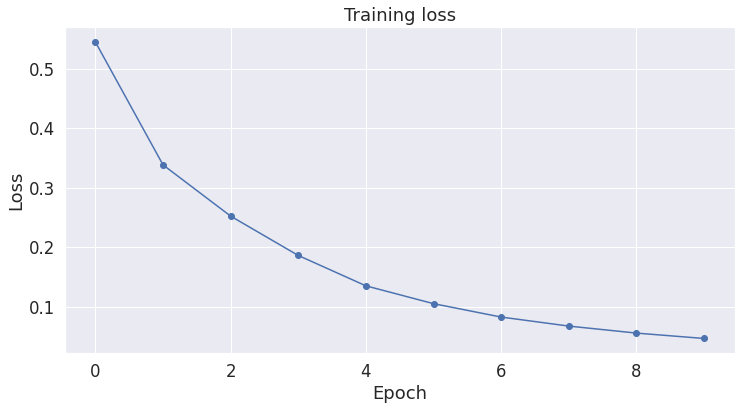

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [ ]:
# Commented to prevent accidental override

output_path = r'/content/drive/MyDrive/fusemachines/sentiment-analysis/output/5/'
tokenizer.save_pretrained(output_path)
model.save_pretrained(output_path)

# Trainer API (Alternate)

In [ ]:
from transformers import TrainingArguments
import numpy as np
import evaluate

training_args = TrainingArguments(
    output_dir="test-trainer", 
    report_to="wandb", 
    evaluation_strategy="epoch",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=10,
    learning_rate=5e-5,
    lr_scheduler_type="polynomial",
    warmup_ratio=0.1,
    save_strategy="epoch",
)

PyTorch: setting up devices


In [ ]:
def compute_metrics(eval_preds):
    metric = evaluate.load("f1")

    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average='weighted')

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 26259
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9849
  Number of trainable parameters = 237558531
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss


Saving model checkpoint to test-trainer/checkpoint-500
Configuration saved in test-trainer/checkpoint-500/config.json
Model weights saved in test-trainer/checkpoint-500/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-500/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-500/special_tokens_map.json
Saving model checkpoint to test-trainer/checkpoint-1000
Configuration saved in test-trainer/checkpoint-1000/config.json
Model weights saved in test-trainer/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-1000/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to test-trainer/checkpoint-1500
Configuration saved in test-trainer/checkpoint-1500/config.json
Model weights saved in test-trainer/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-1500/tokenizer_config.json
Special tokens file saved

Epoch,Training Loss,Validation Loss,F1
1,1.001700,1.001778,0.280942
2,1.004400,1.001281,0.280942
3,0.999100,1.000175,0.280942


Saving model checkpoint to test-trainer/checkpoint-2500
Configuration saved in test-trainer/checkpoint-2500/config.json
Model weights saved in test-trainer/checkpoint-2500/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-2500/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-2500/special_tokens_map.json
Saving model checkpoint to test-trainer/checkpoint-3000
Configuration saved in test-trainer/checkpoint-3000/config.json
Model weights saved in test-trainer/checkpoint-3000/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-3000/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-3000/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3282
  Batch size = 8
Saving model checkpoint to test-trainer/checkpoint-3500
Configuration saved in test-trainer/checkpoint-3500/config.json
Model weights saved in test-trainer/checkpoint-3500/pytorch_model.bin
tokenizer config file saved in t

TrainOutput(global_step=9849, training_loss=1.0001978235615607, metrics={'train_runtime': 2435.3251, 'train_samples_per_second': 32.348, 'train_steps_per_second': 4.044, 'total_flos': 3647833201411056.0, 'train_loss': 1.0001978235615607, 'epoch': 3.0})

# Evaluate model

In [10]:
import torch
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint
from tqdm.auto import tqdm

In [11]:
saved_path = r'/content/drive/MyDrive/fusemachines/sentiment-analysis/output/5/'
checkpoint = saved_path

# checkpoint = './checkpoints/checkpoint-3/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
config = AutoConfig.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config)
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(197285, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [14]:
# tokenizer.push_to_hub('ashishlamsal/binary-sentiment-analysis-nepali')
# model.push_to_hub('ashishlamsal/binary-sentiment-analysis-nepali')

CommitInfo(commit_url='https://huggingface.co/ashishlamsal/binary-sentiment-analysis-nepali/commit/b06cea5f008d081720323a2bd28704c59bd8d7d6', commit_message='Upload BertForSequenceClassification', commit_description='', oid='b06cea5f008d081720323a2bd28704c59bd8d7d6', pr_url=None, pr_revision=None, pr_num=None)

In [50]:
eval_loss, results, report, y_true_list, y_pred_list = validate_model(model, test_dataloader, desc="Testing")

print("  Average Validation Loss: {0:.2f}".format(eval_loss))
for key, value in results.items():
    print("  {}: {:.2f}".format(key,value))

Predicting labels for 56 batches...


Testing:   0%|          | 0/56 [00:00<?, ?it/s]

  Average Validation Loss: 0.38
  accuracy: 0.85
  precision: 0.85
  recall: 0.85
  f1-score: 0.85


In [51]:
pprint(report)

{'accuracy': 0.8529745042492918,
 'macro avg': {'f1-score': 0.8521157337439063,
               'precision': 0.8541423354822635,
               'recall': 0.8512912870585532,
               'support': 3530},
 'negative': {'f1-score': 0.8408463661453541,
              'precision': 0.865530303030303,
              'recall': 0.817531305903399,
              'support': 1677},
 'postive': {'f1-score': 0.8633851013424585,
             'precision': 0.8427543679342241,
             'recall': 0.8850512682137075,
             'support': 1853},
 'weighted avg': {'f1-score': 0.8526776058961288,
                  'precision': 0.8535745501314265,
                  'recall': 0.8529745042492918,
                  'support': 3530}}


In [52]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.rcParams["figure.figsize"] = (10,5)
  plt.ylabel('True Sentiment')
  plt.xlabel('Predicted Sentiment');

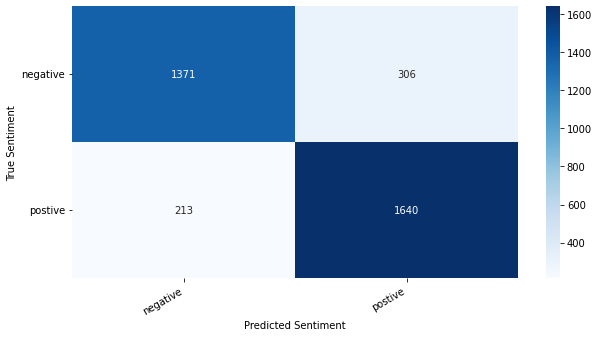

In [53]:
class_names = config.label2id.keys()
cm = confusion_matrix(y_true_list, y_pred_list)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [54]:
print(classification_report(y_true_list, y_pred_list, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.87      0.82      0.84      1677
     postive       0.84      0.89      0.86      1853

    accuracy                           0.85      3530
   macro avg       0.85      0.85      0.85      3530
weighted avg       0.85      0.85      0.85      3530



In [ ]:
wandb.finish()

accuracy,▁▅▆▅█▁▆█▅▅
avg_eval_loss,▂▁▁▂▄▅▆▇██
avg_train_accuracy,▁▄▆▆▇▇████
avg_train_loss,█▅▄▃▂▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
f1-score,▂▅▆▅█▁▆█▅▅
precision,▂▅▆▅█▁▆█▅▅
recall,▁▅▆▅█▁▆█▅▅
train_batch_loss,█████████▇▇▆▆▆▅▄▅▄▅▄▅▂▃▂▂▁▅▃▂▃▁▂▂
accuracy,0.85354
avg_eval_loss,0.70142
